In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC  
from sklearn import preprocessing
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from constants import TVC02
sites = pd.DataFrame({'site':TVC02})
sites.site.replace({'RS':'RP'}, regex=True, inplace=True)
sites=list(sites.site.values)
#sites

In [3]:
density = pd.read_pickle(r"C:\Users\MontpetitB\Documents\Git\tvc_background\data\Scaled_SMP_DENS.pkl")
density.site.replace({'RS':'RP'}, regex=True, inplace=True)
density = density.query('site in @sites')
density.head(10)

,rel_height,force_median,lambda,f0,delta,l,smp_val,height,rel_height,ref_val,grain_type,site
11,26.25,0.830939,9344.535014,0.021799,0.019692,0.152437,291.830000,405.0,15.0,323.0,M,RP20
12,66.25,4.881592,8510.494515,0.854237,0.033236,0.260561,316.908333,375.0,45.0,407.0,M,RP20
13,107.50,15.662411,7056.699464,0.256844,0.030647,0.164570,411.228571,345.0,75.0,327.0,F,RP20
14,148.75,5.249480,4201.457445,0.169653,0.020203,0.177835,363.983333,315.0,105.0,226.0,F,RP20
15,172.50,5.330498,3286.285552,0.134100,0.025485,0.183943,365.400000,285.0,135.0,236.0,H,RP20
16,191.25,7.566322,4003.493626,0.517961,0.030735,0.235927,368.825000,255.0,165.0,216.0,H,RP20
17,227.50,3.913880,777.165520,0.722486,0.073600,0.596650,288.885714,225.0,195.0,226.0,H,RP20
18,262.50,0.365790,52.757954,0.228091,0.090119,0.830495,239.042857,195.0,225.0,230.0,H,RP20
19,280.00,0.059853,18.892237,0.103557,0.118621,1.092456,231.928571,165.0,255.0,215.0,H,RP20
20,318.75,0.108580,22.875895,0.110663,0.109539,0.956315,225.925000,135.0,285.0,236.0,H,RP20


In [4]:
ssa = pd.read_pickle(r"C:\Users\MontpetitB\Documents\Git\tvc_background\data\Scaled_SMP_SSA.pkl")
ssa.site.replace({'RS':'RP'}, regex=True, inplace=True)
ssa.head(10)

,rel_height,force_median,lambda,f0,delta,l,smp_val,height,rel_height,ref_val,grain_type,site
0,16.25,0.819363,7664.622753,0.031158,0.019934,0.174219,289.708333,265.0,15.0,38.518106,N,RP02
1,72.50,10.128936,9051.925711,0.526287,0.029267,0.199798,353.184000,225.0,55.0,21.502542,F,RP02
2,137.50,7.195947,5646.323617,0.186046,0.020084,0.168392,378.236364,175.0,105.0,11.840608,F,RP02
3,163.75,4.683177,4203.937184,0.116177,0.021149,0.171009,362.075000,125.0,155.0,12.397157,F,RP02
4,176.25,5.653160,2601.015663,0.153049,0.028435,0.196545,365.700000,75.0,205.0,11.831589,H,RP02
5,28.75,0.842039,9429.037481,0.021004,0.019696,0.150917,292.472727,185.0,15.0,11.066572,F,RP47
6,65.00,1.267721,11131.789456,0.217118,0.042776,0.255229,298.514286,155.0,45.0,10.623868,H,RP47
7,83.75,21.616841,6731.396525,1.277894,0.029537,0.230718,411.962500,125.0,75.0,9.776917,H,RP47
8,103.75,14.820552,5207.001302,0.307017,0.035105,0.182296,407.137500,95.0,105.0,7.375951,H,RP47
9,125.00,10.578728,6409.327220,0.215853,0.023843,0.162772,397.511111,65.0,135.0,8.076853,H,RP47


In [5]:
class_data = pd.DataFrame({'rel_height': density.rel_height.iloc[:,0], 'site':density.site,
                            'F_med':density.force_median, 'L':density.l, 
                            'rho':density.ref_val, 'type':density.grain_type})
class_data.head(10)

,rel_height,site,F_med,L,rho,type
11,26.25,RP20,0.830939,0.152437,323.0,M
12,66.25,RP20,4.881592,0.260561,407.0,M
13,107.50,RP20,15.662411,0.164570,327.0,F
14,148.75,RP20,5.249480,0.177835,226.0,F
15,172.50,RP20,5.330498,0.183943,236.0,H
16,191.25,RP20,7.566322,0.235927,216.0,H
17,227.50,RP20,3.913880,0.596650,226.0,H
18,262.50,RP20,0.365790,0.830495,230.0,H
19,280.00,RP20,0.059853,1.092456,215.0,H
20,318.75,RP20,0.108580,0.956315,236.0,H


In [6]:
ssas = []
for i in range(len(class_data)):
    
    temp_data = class_data.iloc[i].copy()
    
    ssa_temp = ssa[ssa.site==temp_data.site]
    
    ssas.append(ssa_temp[np.abs(ssa_temp.rel_height.iloc[:,0]-temp_data.rel_height)==
                         np.abs(ssa_temp.rel_height.iloc[:,0]-temp_data.rel_height).min()].ref_val.values[0])
class_data['ssa']=ssas

In [7]:
class_data=class_data.query('site in @sites')
class_data

,rel_height,site,F_med,L,rho,type,ssa
11,26.25,RP20,0.830939,0.152437,323.0,M,59.673331
12,66.25,RP20,4.881592,0.260561,407.0,M,52.017675
13,107.50,RP20,15.662411,0.164570,327.0,F,33.944069
14,148.75,RP20,5.249480,0.177835,226.0,F,21.074667
15,172.50,RP20,5.330498,0.183943,236.0,H,13.834073
...,...,...,...,...,...,...,...
586,113.75,RP29,13.713664,0.175198,183.0,H,15.837828
587,160.00,RP29,4.553629,0.170306,173.0,H,13.229149
588,177.50,RP29,5.496339,0.172708,197.0,H,13.229149
589,195.00,RP29,7.310067,0.438541,174.0,H,13.071023


In [8]:
class_data.type.unique()

array(['M', 'F', 'H'], dtype=object)

In [9]:
import matplotlib

font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

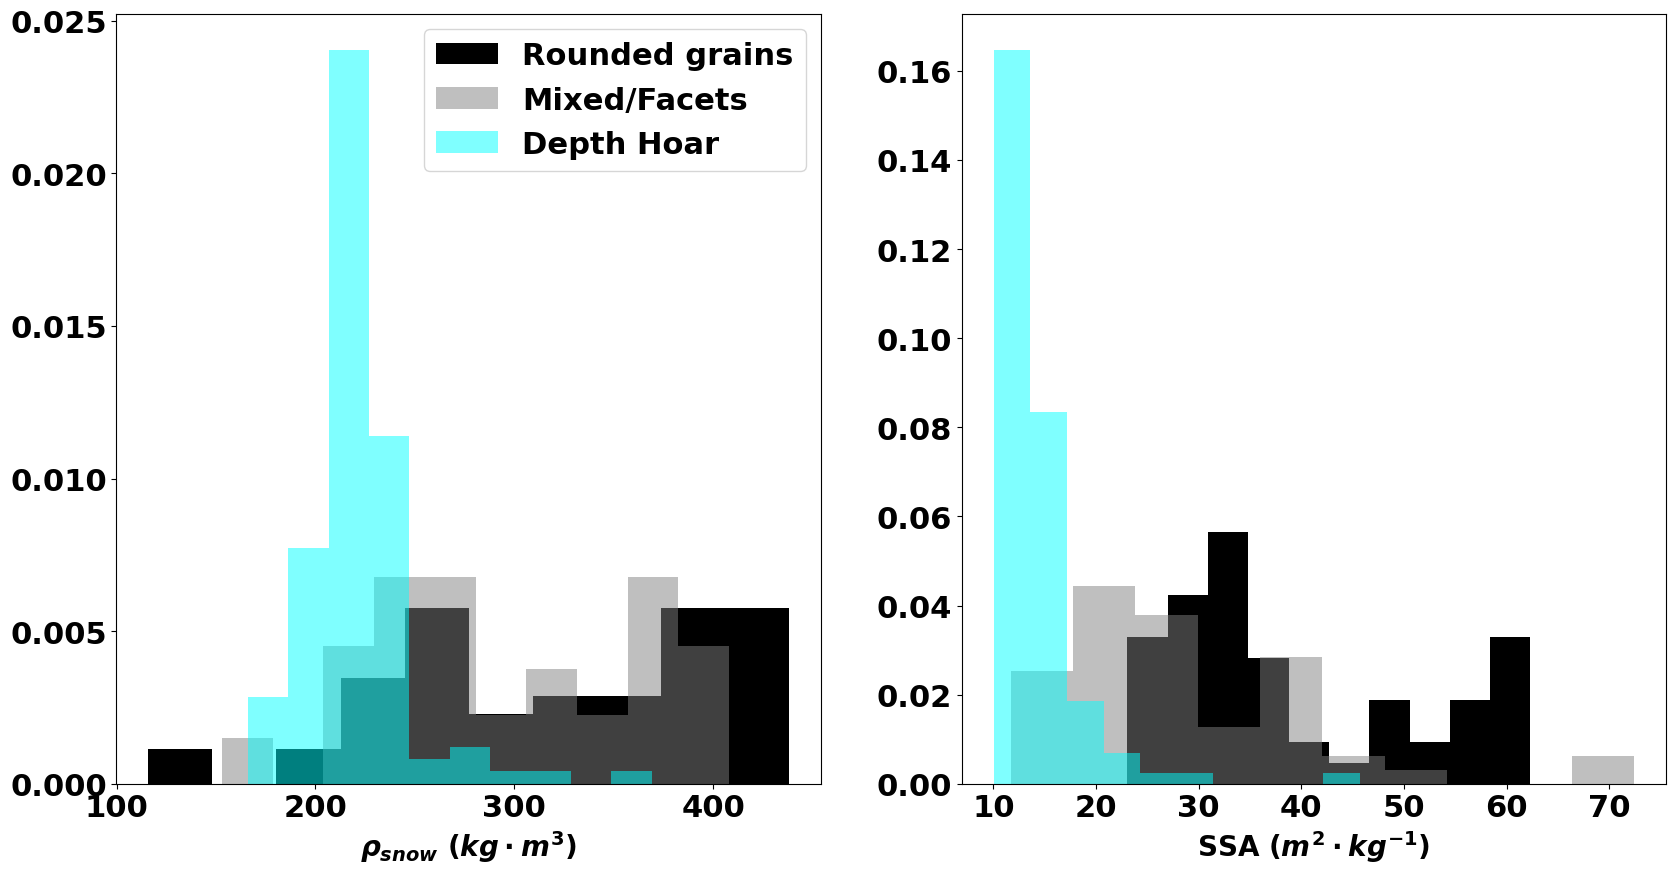

In [33]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

hist_rho_ws=ax[0].hist(class_data.rho[class_data.type=='M'], bins=10, density=True, alpha=1, label='Rounded grains', color='k')
hist_rho_f=ax[0].hist(class_data.rho[class_data.type=='F'], bins=10, density=True, alpha=0.5, label='Mixed/Facets', color='grey')
hist_rho_dh=ax[0].hist(class_data.rho[class_data.type=='H'], bins=10, density=True, alpha=0.5, label='Depth Hoar', color='cyan')

hist_ssa_ws=ax[1].hist(class_data.ssa[class_data.type=='M'], bins=10, density=True, alpha=1, color='k')
hist_ssa_f=ax[1].hist(class_data.ssa[class_data.type=='F'], bins=10, density=True, alpha=0.5, color='grey')
hist_ssa_dh=ax[1].hist(class_data.ssa[class_data.type=='H'], bins=10, density=True, alpha=0.5, color='cyan')

ax[0].set_xlabel('$\\rho_{snow}$ $(kg \\cdot m^3)$',fontsize=20, fontweight='bold')
ax[1].set_xlabel('SSA ($m^2 \\cdot kg^{-1}$)',fontsize=20, fontweight='bold')
ax[0].legend()

In [11]:
class_data.loc[:,'class_type'] = class_data.type.values
class_data = class_data.loc[class_data.type.isin(['M', 'H', 'F'])]
class_data.loc[class_data.type != 'H','type'] = 'M'
class_data.type.unique()

array(['M', 'H'], dtype=object)

In [15]:
model_data = pd.concat([class_data.loc[class_data.type=='H'].sample(len(class_data.loc[class_data.type=='M'])), class_data.loc[class_data.type=='M']])

X = model_data.drop(['type','class_type','site', 'ssa','rho'], axis=1)
y = model_data['type']

In [16]:
X

,rel_height,F_med,L
404,182.50,6.096321,0.178443
480,370.00,0.193466,1.081703
166,261.25,0.475947,0.933994
588,177.50,5.496339,0.172708
97,391.25,0.157772,1.454212
...,...,...,...
531,58.75,2.358279,0.221313
532,116.25,13.311223,0.171051
583,10.00,0.759956,0.208129
584,27.50,0.890092,0.123816


In [17]:
RANDOM_SEED = 2023
stratified_shuffle = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=RANDOM_SEED)
stratified_shuffle.get_n_splits(X, y)

10

In [18]:
svclassifier = SVC(kernel='linear', gamma='scale', probability = True)

In [19]:
scores = cross_val_score(svclassifier, preprocessing.scale(X), y.values, cv = stratified_shuffle, scoring = 'accuracy')
print("Accuracy: %0.1f (+/- %0.1f)" % (scores.mean()*100, scores.std()*100))

Accuracy: 80.7 (+/- 5.1)


In [20]:
from matplotlib import pyplot as plt

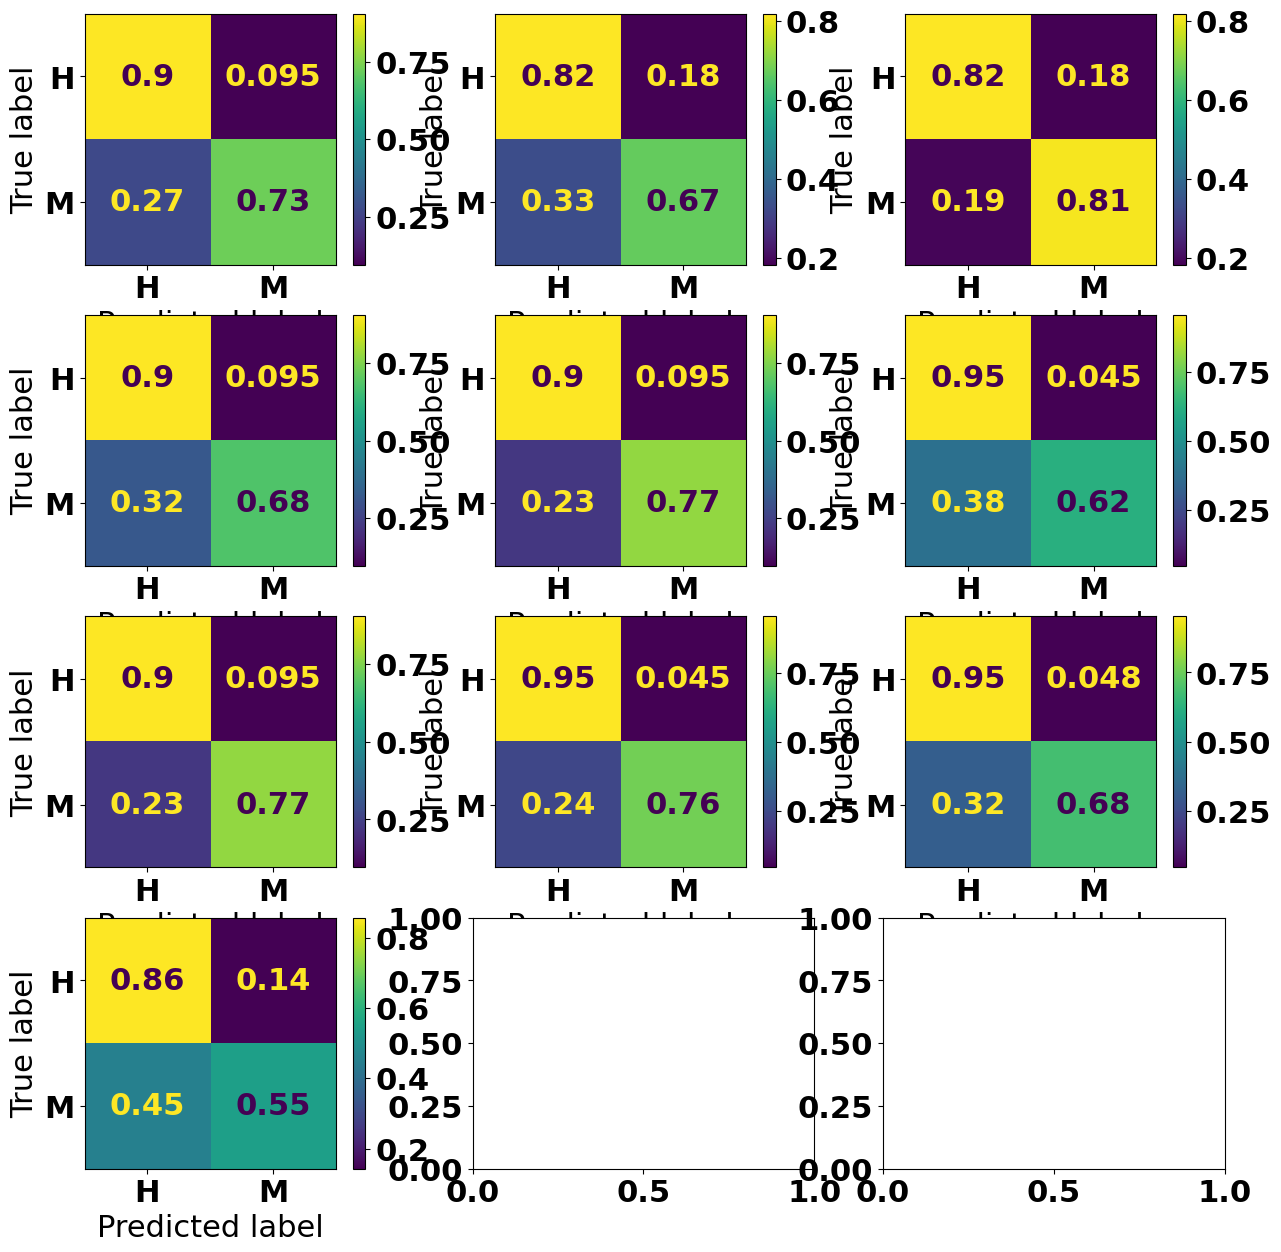

In [21]:
conf_mat_full = None 

fig, ax = plt.subplots(4,3,figsize=(15,15))

i=0
j=0
k=0

for train, test in stratified_shuffle.split(X, y):
    svclassifier.fit(X.iloc[train], y.iloc[train].values)
    ypred = svclassifier.predict(X.iloc[test])
    conf_mat = confusion_matrix(y.iloc[test].values, ypred, labels=["M", "H"])
    
    if conf_mat_full is None:
        conf_mat_full = conf_mat
    else:
        conf_mat_full = conf_mat_full + conf_mat
    
    ConfusionMatrixDisplay.from_predictions(y.iloc[test].values,ypred, normalize='true', ax=ax[j,i])
    # ax[j,i].set_title(k)
    k+=1
    i+=1
    if i==3:
        i=0
        j+=1

In [22]:
conf_mat_full

array([[152,  64],
       [ 22, 192]], dtype=int64)

In [23]:
[conf_mat_full[0,:]/conf_mat_full[0,:].sum(),
 conf_mat_full[:,1]/conf_mat_full[:,1].sum()]

[array([0.7037037, 0.2962963]), array([0.25, 0.75])]

In [25]:
import pickle
pickle.dump(svclassifier, open(r'data/SVClassifierTVC02_2.pkl', 'wb'))

In [26]:
len(model_data.loc[model_data.type=='H'])/len(model_data.loc[model_data.type=='M'])

1.0

In [28]:
class_data = pd.DataFrame({'rel_height': density.rel_height.iloc[:,0], 'site':density.site,
                            'F_med':density.force_median, 'L':density.l, 
                            'rho':density.ref_val, 'type':density.grain_type})

ssas = []
for i in range(len(class_data)):
    
    temp_data = class_data.iloc[i].copy()
    
    ssa_temp = ssa[ssa.site==temp_data.site]
    
    ssas.append(ssa_temp[np.abs(ssa_temp.rel_height.iloc[:,0]-temp_data.rel_height)==
                         np.abs(ssa_temp.rel_height.iloc[:,0]-temp_data.rel_height).min()].ref_val.values[0])
class_data['ssa']=ssas

class_data.loc[:,'class_type']=class_data.type.values

class_data.loc[:,'class_type']=svclassifier.predict(class_data.drop(['type','class_type','site', 'ssa', 'rho'], axis=1))

In [29]:
class_data.class_type.unique()

array(['M', 'H'], dtype=object)

In [31]:
original = 'F'
final = 'M'
len(class_data.loc[(class_data.type==original) & (class_data.class_type==final)])/len(class_data.loc[(class_data.type==original)])

0.5

In [32]:
h_frac=[]
for site in class_data.site.unique():
    temp_prof = class_data.loc[class_data.site==site]
    temp_prof.loc[:,'thickness'] = temp_prof.rel_height.diff().values
    temp_prof.loc[temp_prof.index[0],'thickness']=class_data.iloc[0].rel_height
    h_frac.append(temp_prof.loc[(temp_prof.class_type=='H')].thickness.sum()/temp_prof.thickness.sum())

C:\Users\MontpetitB\AppData\Local\Temp\ipykernel_21892\671410077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_prof.loc[:,'thickness'] = temp_prof.rel_height.diff().values
C:\Users\MontpetitB\AppData\Local\Temp\ipykernel_21892\671410077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_prof.loc[:,'thickness'] = temp_prof.rel_height.diff().values
C:\Users\MontpetitB\AppData\Local\Temp\ipykernel_21892\671410077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [120]:
np.median(h_frac)

0.3702127659574468

# **************************************************

In [40]:
class_data = pd.DataFrame({'rel_height': density.rel_height.iloc[:,0], 'site':density.site,
                            'F_med':density.force_median, 'L':density.l, 
                            'rho':density.smp_val, 'type':density.grain_type})
class_data.head(10)

,rel_height,site,F_med,L,rho,type
0,12.50,SD01,0.017383,0.137978,125.114286,N
1,30.00,SD01,0.044256,0.367083,172.000000,N
2,48.75,SD01,0.028776,0.343521,161.650000,F
3,67.50,SD01,0.034860,0.330122,171.185714,F
4,86.25,SD01,0.069144,0.536272,194.775000,F
5,130.00,SD01,0.065456,0.457790,197.111111,F
6,176.25,SD01,0.079125,0.468274,204.320000,H
11,28.75,RP20,1.999456,0.148287,329.372727,M
12,70.00,RP20,17.116735,0.202061,405.581818,M
13,108.75,RP20,5.763592,0.521895,290.105000,F


In [41]:
ssas = []
for i in range(len(class_data)):
    
    temp_data = class_data.iloc[i].copy()
    
    ssa_temp = ssa[ssa.site==temp_data.site]
    
    ssas.append(ssa_temp[np.abs(ssa_temp.rel_height.iloc[:,0]-temp_data.rel_height)==
                         np.abs(ssa_temp.rel_height.iloc[:,0]-temp_data.rel_height).min()].smp_val.values[0])
class_data['ssa']=ssas

In [42]:
class_data.loc[:,'class_type'] = class_data.type.values
class_data.loc[class_data.type != 'H','class_type'] = 'C'
class_data.head(10)

,rel_height,site,F_med,L,rho,type,ssa,class_type
0,12.50,SD01,0.017383,0.137978,125.114286,N,25.771429,C
1,30.00,SD01,0.044256,0.367083,172.000000,N,25.771429,C
2,48.75,SD01,0.028776,0.343521,161.650000,F,25.771429,C
3,67.50,SD01,0.034860,0.330122,171.185714,F,25.771429,C
4,86.25,SD01,0.069144,0.536272,194.775000,F,25.771429,C
5,130.00,SD01,0.065456,0.457790,197.111111,F,26.180000,C
6,176.25,SD01,0.079125,0.468274,204.320000,H,23.416667,H
11,28.75,RP20,1.999456,0.148287,329.372727,M,34.837500,C
12,70.00,RP20,17.116735,0.202061,405.581818,M,29.546154,C
13,108.75,RP20,5.763592,0.521895,290.105000,F,18.100000,C


In [103]:
X = class_data.drop(['type','class_type','rel_height','site'], axis=1)
y = class_data['class_type']

In [104]:
RANDOM_SEED = 2023
stratified_shuffle = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=RANDOM_SEED)
stratified_shuffle.get_n_splits(X, y)

10

In [109]:
svclassifier = SVC(kernel='linear', gamma='scale', probability = True)

In [110]:
scores = cross_val_score(svclassifier, preprocessing.scale(X), y.values, cv = stratified_shuffle, scoring = 'accuracy')
print("Accuracy: %0.1f (+/- %0.1f)" % (scores.mean()*100, scores.std()*100))

Accuracy: 85.6 (+/- 1.7)


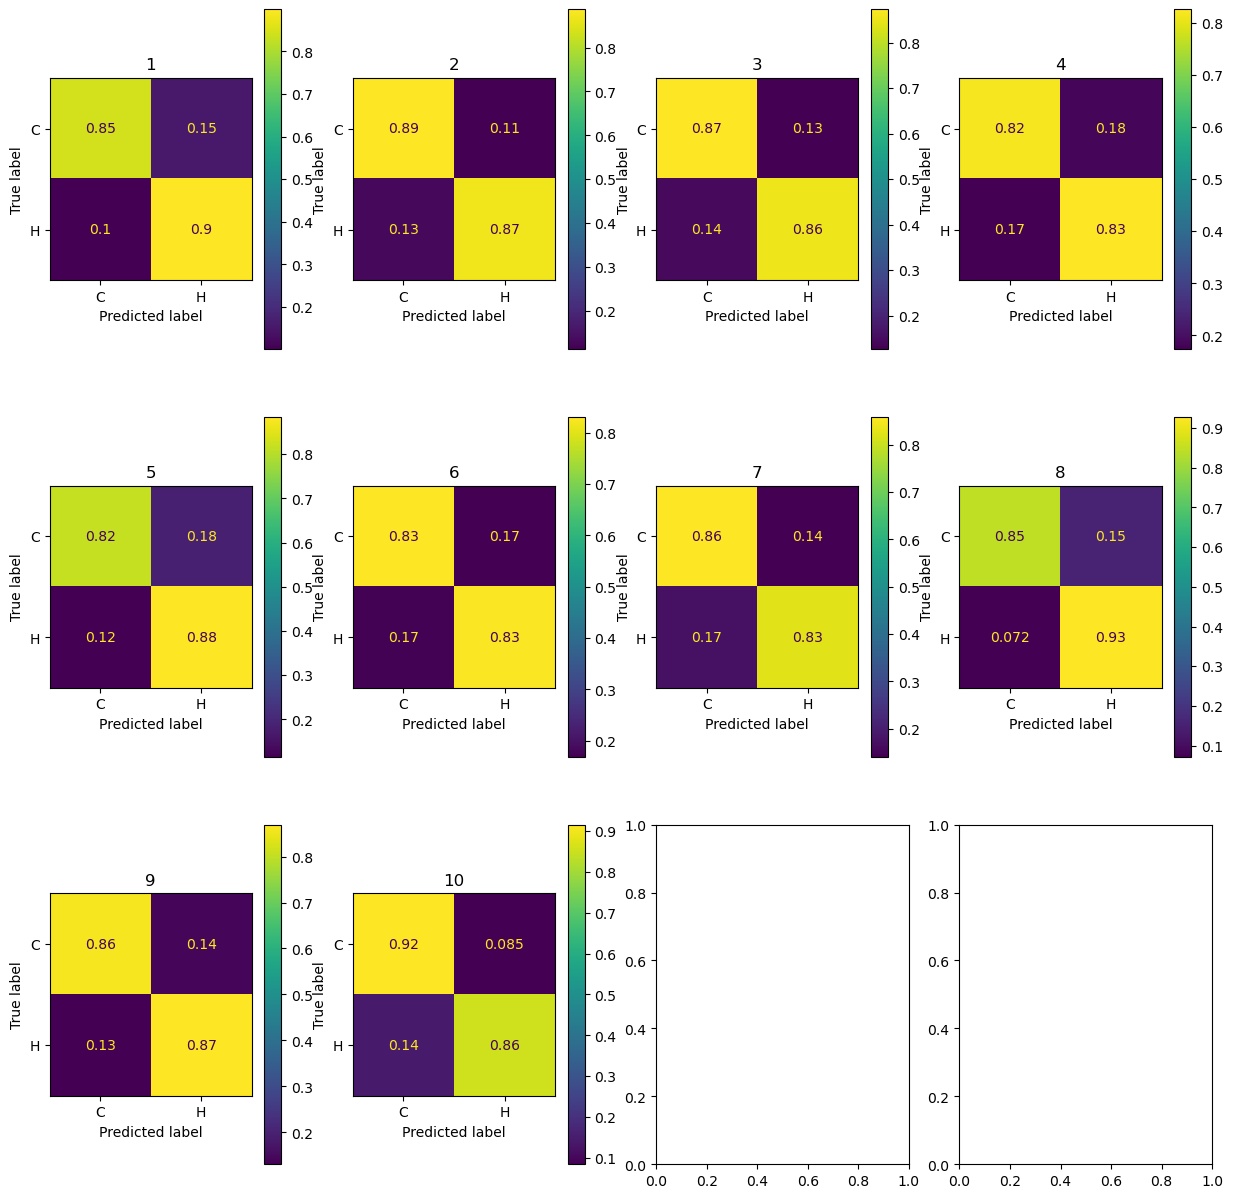

In [111]:
conf_mat_full = None 

fig, ax = plt.subplots(3,4,figsize=(15,15))

i=0
j=0
k=1

for train, test in stratified_shuffle.split(X, y):
    svclassifier.fit(X.iloc[train], y.iloc[train].values)
    ypred = svclassifier.predict(X.iloc[test])
    conf_mat = confusion_matrix(y.iloc[test].values, ypred, labels=["C", "H"])
    
    if conf_mat_full is None:
        conf_mat_full = conf_mat
    else:
        conf_mat_full = conf_mat_full + conf_mat
    
    ConfusionMatrixDisplay.from_predictions(y.iloc[test].values,ypred, normalize='true', ax=ax[j,i])
    ax[j,i].set_title(str(k))
    k+=1
    i+=1
    if i==4:
        i=0
        j+=1

In [112]:
[conf_mat_full[0,:]/conf_mat_full[0,:].sum(),
 conf_mat_full[:,1]/conf_mat_full[:,1].sum()]

[array([0.85492958, 0.14507042]), array([0.14735336, 0.85264664])]

In [113]:
import pickle
pickle.dump(svclassifier, open(r'data/SVClassifierAll.pkl', 'wb'))

In [114]:
class_data.loc[:,'pred']=svclassifier.predict(X)
class_data

,rel_height,site,F_med,L,rho,type,ssa,class_type,pred
0,12.50,SD01,0.017383,0.137978,125.114286,N,25.771429,C,C
1,30.00,SD01,0.044256,0.367083,172.000000,N,25.771429,C,C
2,48.75,SD01,0.028776,0.343521,161.650000,F,25.771429,C,C
3,67.50,SD01,0.034860,0.330122,171.185714,F,25.771429,C,C
4,86.25,SD01,0.069144,0.536272,194.775000,F,25.771429,C,C
...,...,...,...,...,...,...,...,...,...
702,83.75,RP15,0.016865,0.868870,212.133333,F,14.171429,C,H
703,105.00,RP15,0.017386,1.341382,267.463636,F,8.985000,C,H
704,10.00,RP09,0.074605,0.558012,207.285714,F,20.218750,C,C
705,27.50,RP09,0.942710,0.414587,278.428571,F,20.218750,C,C


In [123]:
for gtype in class_data.type.unique():
    
    print('% of good predictions for grain type ' + gtype + ' = %0.1f' % 
           (class_data.loc[(class_data.type==gtype) & (class_data.class_type==class_data.pred)].shape[0]/
           class_data.loc[class_data.type==gtype].shape[0]*100))

% of good predictions for grain type N = 100.0
% of good predictions for grain type F = 77.1
% of good predictions for grain type H = 83.9
% of good predictions for grain type M = 97.1
% of good predictions for grain type R = 90.2


In [119]:
class_data = pd.DataFrame({'rel_height': density.rel_height.iloc[:,0], 'site':density.site,
                            'F_med':density.force_median, 'L':density.l, 
                            'rho':density.smp_val, 'type':density.grain_type})

class_data.loc[(class_data.type==gtype) & (class_data.class_type==class_data.pred)].shape[0]

8

# **************************************************

In [177]:
smp_results = pd.read_pickle(r"Data/smp_result.pkl")
smp_results

,site,position,density,ssa
0,RS01,RHO,rel_height force_median lambda ...,rel_height force_median lambda ...
1,RS01,SSA,rel_height force_median lambda ...,rel_height force_median lambda ...
2,RS01,N1,rel_height force_median lambda ...,rel_height force_median lambda ...
3,RS01,N2,rel_height force_median lambda ...,rel_height force_median lambda ...
4,RS01,N3,rel_height force_median lambda ...,rel_height force_median lambda ...
...,...,...,...,...
1381,SV03,W3,rel_height force_median lambda ...,rel_height force_median lambda ...
1382,SV03,RHO,rel_height force_median lambda ...,rel_height force_median lambda ...
1383,SV03,RHO1,rel_height force_median lambda ...,rel_height force_median lambda ...
1384,SV03,SSA,rel_height force_median lambda ...,rel_height force_median lambda ...


In [125]:
smp_results[(smp_results.site=='SM02') & (smp_results.position=='RHO')].iloc[0].density

,rel_height,force_median,lambda,f0,delta,l,density
0,0.0,0.059195,3838.503803,0.001199,0.025948,0.172302,165.1
1,2.5,0.053934,1177.964090,0.002498,0.036092,0.255446,166.3
2,5.0,0.040779,1707.174249,0.002143,0.022548,0.225727,152.1
3,7.5,0.034202,2710.573051,0.001480,0.016758,0.193489,141.6
4,10.0,0.030255,3707.476374,0.001192,0.013895,0.174308,134.2
...,...,...,...,...,...,...,...
162,405.0,7.812476,332.906276,0.372871,0.127906,0.389257,356.6
163,407.5,8.247233,115.636743,0.563105,0.257827,0.553747,332.1
164,410.0,8.078855,89.341824,0.665588,0.275264,0.603474,323.6
165,412.5,6.279315,170.063524,0.895576,0.089839,0.486937,334.1


In [130]:
smp_results[(smp_results.site=='SM02') & (smp_results.position=='RHO')].iloc[0].ssa

,rel_height,force_median,lambda,f0,delta,l,ssa
0,0.0,0.059195,3838.503803,0.001199,0.025948,0.172302,43.085777
1,2.5,0.053934,1177.964090,0.002498,0.036092,0.255446,32.963878
2,5.0,0.040779,1707.174249,0.002143,0.022548,0.225727,36.515781
3,7.5,0.034202,2710.573051,0.001480,0.016758,0.193489,41.061553
4,10.0,0.030255,3707.476374,0.001192,0.013895,0.174308,44.467446
...,...,...,...,...,...,...,...
162,405.0,7.812476,332.906276,0.372871,0.127906,0.389257,18.347859
163,407.5,8.247233,115.636743,0.563105,0.257827,0.553747,14.320673
164,410.0,8.078855,89.341824,0.665588,0.275264,0.603474,13.507443
165,412.5,6.279315,170.063524,0.895576,0.089839,0.486937,15.911117


In [178]:
for i in range(len(smp_results)):
    
    print(i)
    
    class_data = pd.DataFrame({'rel_height': smp_results.iloc[i].density.rel_height, 
                               'site': smp_results.iloc[i].site,
                               'F_med': smp_results.iloc[i].density.force_median, 
                               'L': smp_results.iloc[i].density.l, 
                               'rho': smp_results.iloc[i].density.density, 
                               'ssa': smp_results.iloc[i].ssa.ssa})
    
    class_data.loc[:,'pred']=svclassifier.predict(class_data.drop(['rel_height','site'], axis=1))
    smp_results.iloc[i].density.loc[:,'pred'] = class_data.pred

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [192]:
for i in smp_results.index:
    
    print(i)
    pred = smp_results.loc[i].density.pred.values
    smp_results.loc[i,'h_frac'] = ((pred=='H').sum()/len(pred))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
23
24
25
26
27
28
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
66
67
68
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
2

In [213]:
smp_results.site.replace({'RS':'RP'}, regex=True, inplace=True)

In [222]:
from constants import TVC01
from constants import TVC02
from constants import TVC03
TVC01 = pd.DataFrame({'site':TVC01})
TVC02 = pd.DataFrame({'site':TVC02})
TVC03 = pd.DataFrame({'site':TVC03})
TVC01.site.replace({'RS':'RP'}, regex=True, inplace=True)
TVC02.site.replace({'RS':'RP'}, regex=True, inplace=True)
TVC03.site.replace({'RS':'RP'}, regex=True, inplace=True)
TVC02

,site
0,RP16
1,RP17
2,RP18
3,RP19
4,RP20
5,RP21
6,RP22
7,RP23
8,RP24
9,RP25


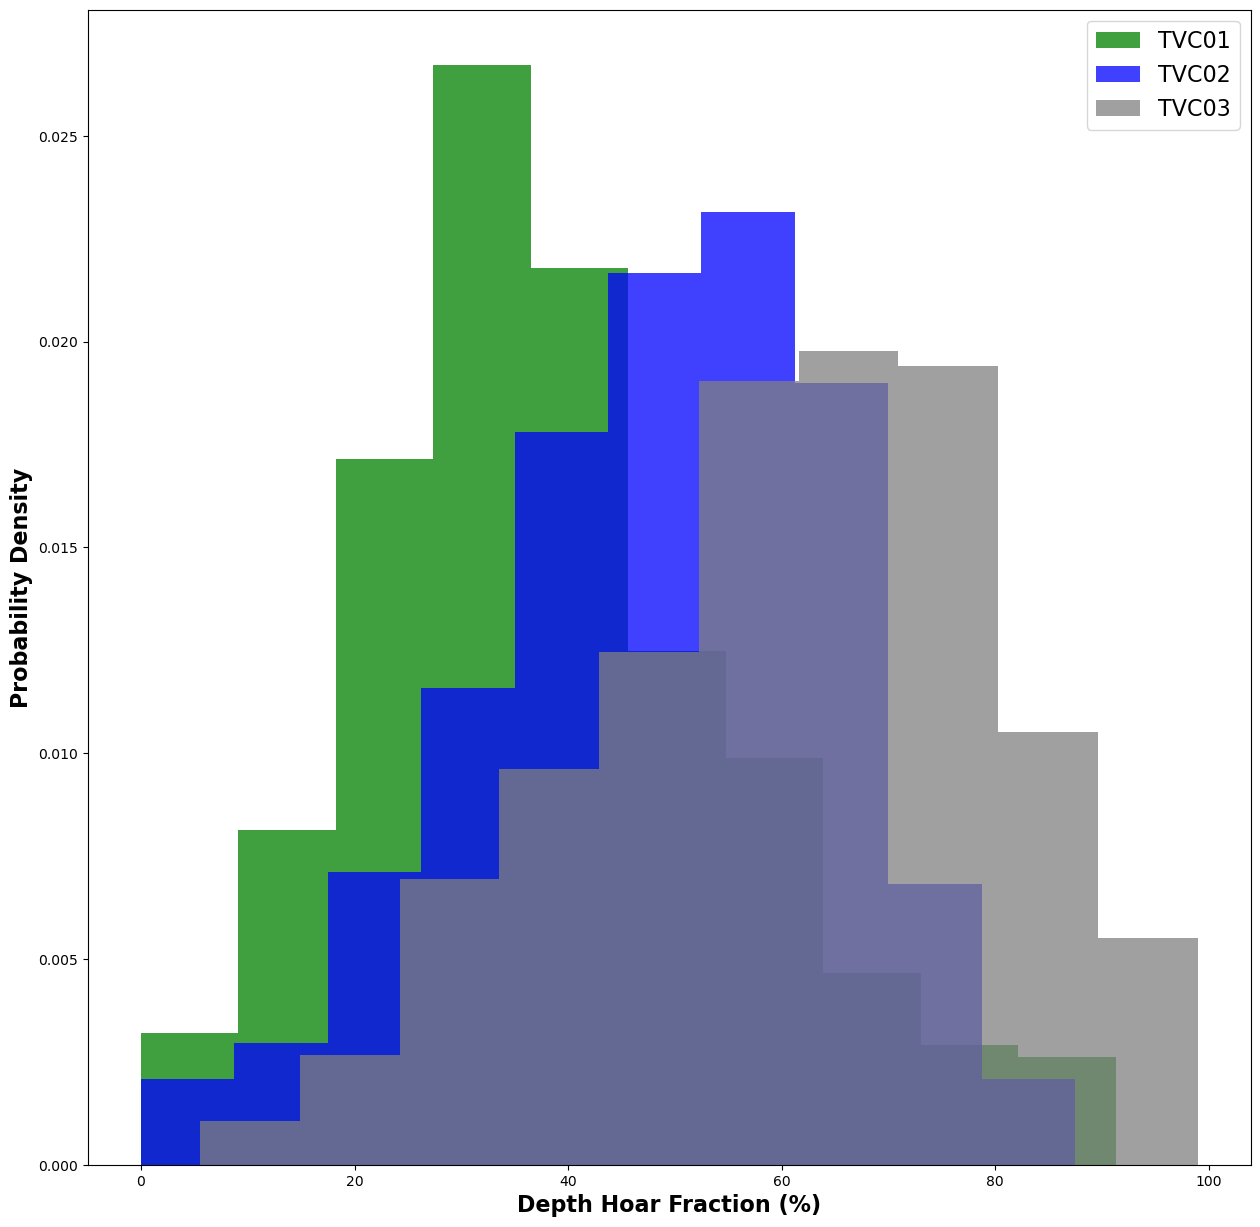

In [232]:
fig, ax = plt.subplots(figsize=(15,15))

outs = ax.hist(smp_results.query('site in @TVC01.site').h_frac*100, bins=10, density=True, 
               color='green', alpha=0.75, label='TVC01')
outs = ax.hist(smp_results.query('site in @TVC02.site').h_frac*100, bins=10, density=True,
               color='blue', alpha=0.75, label='TVC02')
outs = ax.hist(smp_results.query('site in @TVC03.site').h_frac*100, bins=10, density=True,
               color='grey', alpha=0.75, label='TVC03')
ax.set_xlabel('Depth Hoar Fraction (%)', fontsize=16, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=16, fontweight='bold')
ax.legend(fontsize=16)

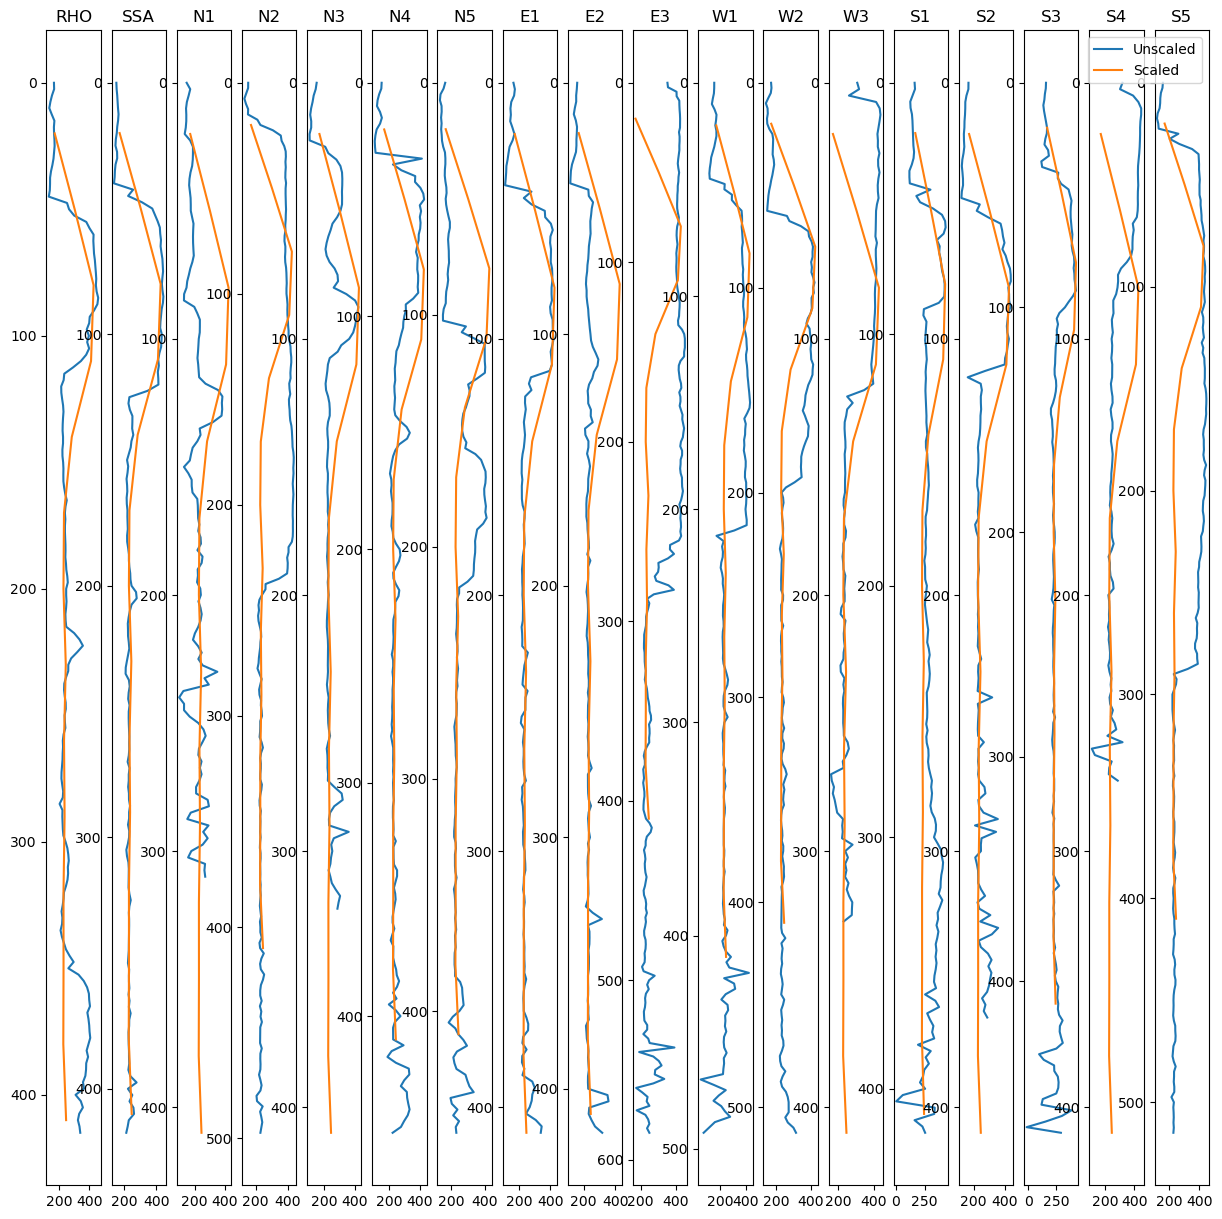

In [126]:
rho = smp_results[(smp_results.site=='SM02')]
rho_scaled = density[density.site=='SM02']

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, len(rho), figsize=(15, 15))

for i in range(len(rho)):

    ax[i].plot(rho.iloc[i].density.density, rho.iloc[i].density.rel_height, label='Unscaled')
    ax[i].plot(rho_scaled.smp_val, rho_scaled.rel_height.iloc[:,1], label='Scaled')
    ax[i].invert_yaxis()
    ax[i].set_title(rho.iloc[i].position)
    
ax[i].legend()

In [127]:
ssa = pd.read_pickle(r"C:\Users\MontpetitB\Documents\Git\tvc_background\data\Scaled_SMP_SSA.pkl")
ssa = ssa[ssa.site=='SM02']
ssa

,delta,f0,force_median,l,lambda,rel_height,smp_val,height,rel_height,ref_val,grain_type,site
309,0.038888,0.567986,6.755635,0.417265,4117.387028,53.75,22.530000,465.0,30.0,25.248614,M,SM02
310,0.054250,0.341488,21.124673,0.192485,9492.111630,87.50,22.542857,415.0,80.0,33.376770,M,SM02
311,0.052612,0.299251,0.331494,0.456522,505.179870,126.25,22.470000,365.0,130.0,30.032164,M,SM02
312,0.079794,0.213947,1.154376,0.523323,207.688359,203.75,14.435000,315.0,180.0,14.483154,H,SM02
313,0.151279,0.074565,0.187244,0.763800,61.477048,277.50,12.426316,265.0,230.0,14.173983,H,SM02
314,0.129076,0.183289,0.436657,0.837011,38.122265,320.00,8.466667,225.0,270.0,12.010745,H,SM02
315,0.106821,0.631641,6.949001,0.557844,455.937055,352.50,9.500000,185.0,310.0,12.449004,H,SM02
316,0.143989,0.380792,9.157433,0.380649,559.865506,392.50,11.357143,135.0,360.0,11.174717,H,SM02
317,0.192866,0.467988,8.029855,0.471502,224.271510,406.25,7.200000,85.0,410.0,12.010745,H,SM02


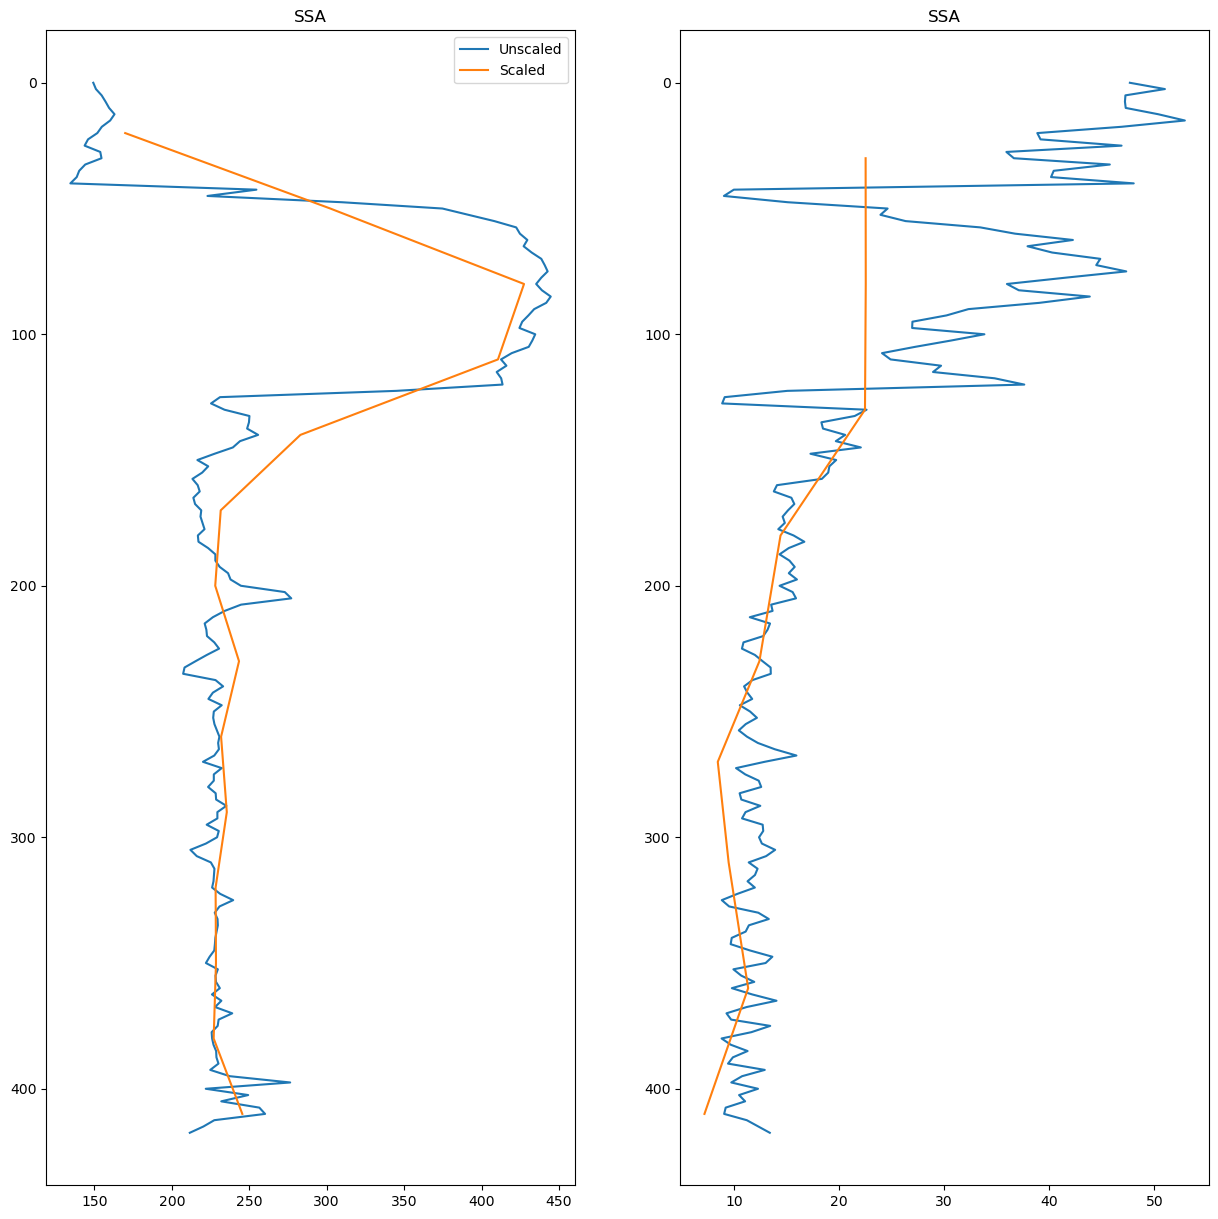

In [128]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].plot(rho.iloc[1].density.density, rho.iloc[1].density.rel_height, label='Unscaled')
ax[0].plot(rho_scaled.smp_val, rho_scaled.rel_height.iloc[:,1], label='Scaled')
ax[0].invert_yaxis()
ax[0].set_title(rho.iloc[1].position)

ax[1].plot(rho.iloc[1].ssa.ssa, rho.iloc[1].ssa.rel_height, label='Unscaled')
ax[1].plot(ssa.smp_val, ssa.rel_height.iloc[:,1], label='Scaled')
ax[1].invert_yaxis()
ax[1].set_title(rho.iloc[1].position)
    
ax[0].legend()

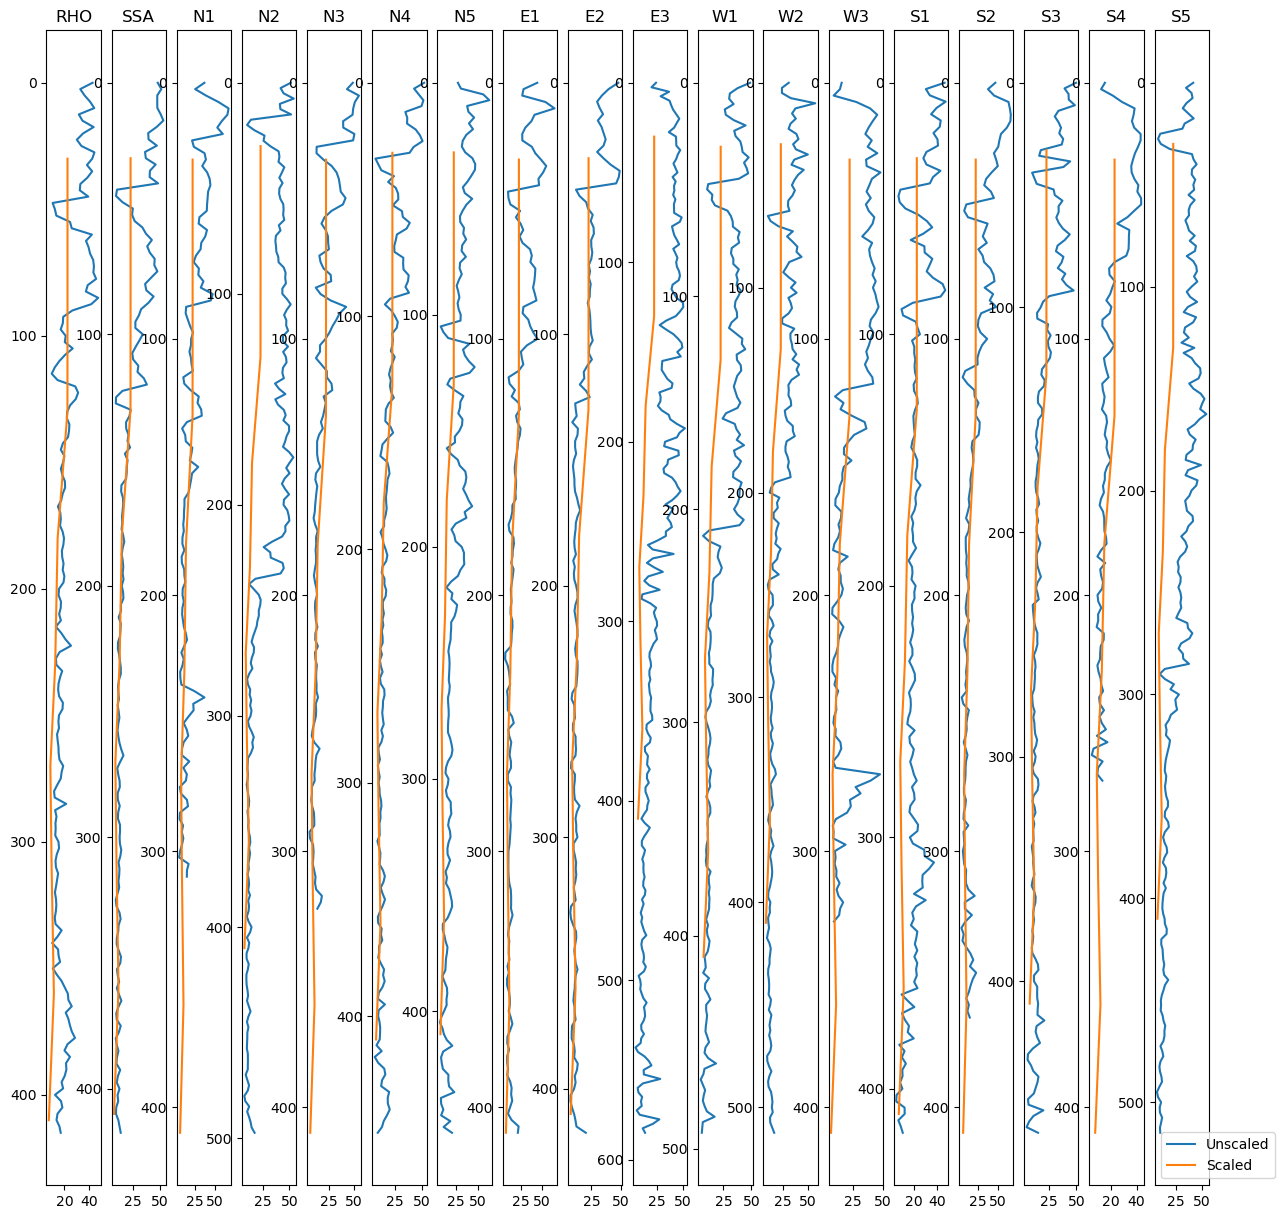

In [129]:
fig, ax = plt.subplots(1, len(rho), figsize=(15, 15))

for i in range(len(rho)):

    ax[i].plot(rho.iloc[i].ssa.ssa, rho.iloc[i].ssa.rel_height, label='Unscaled')
    ax[i].plot(ssa.smp_val, ssa.rel_height.iloc[:,1], label='Scaled')
    ax[i].invert_yaxis()
    ax[i].set_title(rho.iloc[i].position)
    
ax[i].legend()